In [1]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from keras import models, layers

# Paths to files
data_file = r'C:\Users\zanib\OneDrive\Desktop\Year 3 Assignments\fashion_data\styles.csv'
images_folder = r'C:\Users\zanib\OneDrive\Desktop\Year 3 Assignments\fashion_data\images'

# Load the data
data = pd.read_csv(data_file, on_bad_lines='skip')

# Filter the data for the desired classes
filtered_data = data[data['usage'].isin(['Smart', 'Casual', 'Formal'])]

# Map labels to numerical values
label_mapping = {'Smart': 0, 'Casual': 1, 'Formal': 2}
filtered_data.loc[:, 'label'] = filtered_data['usage'].map(label_mapping)

# Convert labels to strings (required for ImageDataGenerator)
filtered_data['label'] = filtered_data['label'].astype(str)

# Add a column for file paths
filtered_data['filename'] = filtered_data['id'].apply(lambda x: os.path.join(images_folder, f"{x}.jpg"))

# Debug: Print unique labels and check if all 3 classes are present
print("Unique labels:", filtered_data['label'].unique())
print("Class distribution:\n", filtered_data['usage'].value_counts())

# Define data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True, #data augmentation
    fill_mode='nearest',
    validation_split=0.2  # Split for validation
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=filtered_data,
    directory=None,
    x_col='filename',
    y_col='label',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    classes=['0', '1', '2']  # Explicitly specify the classes
)

val_generator = train_datagen.flow_from_dataframe(
    dataframe=filtered_data,
    directory=None,
    x_col='filename',
    y_col='label',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    classes=['0', '1', '2']
)


# Load VGG16 pretrained model
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the layers of VGG16
for layer in vgg_base.layers:
    layer.trainable = False
    
from tensorflow.keras import regularizers
network = models.Sequential()
network.add(vgg_base)
network.add(layers.Flatten())
network.add(layers.Dense(256, activation='relu', 
                         kernel_regularizer=regularizers.l2(0.01)))  # L2 regularization
network.add(layers.Dropout(0.5))  # Dropout for regularization
network.add(layers.Dense(3, activation='softmax', 
                         kernel_regularizer=regularizers.l2(0.01)))  # L2 regularization
 # 3 output neurons for 3 classes


# Compile the model
network.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.RMSprop(learning_rate=2e-5),
    metrics=['accuracy']
)



C:\Users\zanib\AppData\Local\Temp\ipykernel_7664\2032729819.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.loc[:, 'label'] = filtered_data['usage'].map(label_mapping)
C:\Users\zanib\AppData\Local\Temp\ipykernel_7664\2032729819.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['label'] = filtered_data['label'].astype(str)
C:\Users\zanib\AppData\Local\Temp\ipykernel_7664\2032729819.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

Unique labels: ['1' '2']
Class distribution:
 usage
Casual    34406
Formal     2345
Name: count, dtype: int64
Found 29397 validated image filenames belonging to 3 classes.


C:\Users\zanib\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 5 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


Found 7349 validated image filenames belonging to 3 classes.


C:\Users\zanib\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\legacy\preprocessing\image.py:920: UserWarning: Found 5 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


In [31]:

history = network.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=val_generator.samples // val_generator.batch_size
)

# Evaluate the model on validation data
test_loss, test_acc = network.evaluate(val_generator)
print(f"Validation Accuracy: {test_acc * 100:.2f}%")

C:\Users\zanib\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
918/918 ━━━━━━━━━━━━━━━━━━━━ 2587s 3s/step - accuracy: 0.9198 - loss: 4.1713 - val_accuracy: 0.9327 - val_loss: 1.7605
Epoch 2/10
  1/918 ━━━━━━━━━━━━━━━━━━━━ 30:54 2s/step - accuracy: 0.9062 - loss: 1.7587

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.2288.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


918/918 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9062 - loss: 1.7587 - val_accuracy: 0.9524 - val_loss: 1.7905
Epoch 3/10
918/918 ━━━━━━━━━━━━━━━━━━━━ 2741s 3s/step - accuracy: 0.9399 - loss: 1.4331 - val_accuracy: 0.9391 - val_loss: 0.8236
Epoch 4/10
918/918 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9375 - loss: 0.7992 - val_accuracy: 0.9048 - val_loss: 0.8332
Epoch 5/10
918/918 ━━━━━━━━━━━━━━━━━━━━ 5179s 6s/step - accuracy: 0.9413 - loss: 0.7453 - val_accuracy: 0.9431 - val_loss: 0.5604
Epoch 6/10
918/918 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9375 - loss: 0.5103 - val_accuracy: 0.9524 - val_loss: 0.5293
Epoch 7/10
918/918 ━━━━━━━━━━━━━━━━━━━━ 2622s 3s/step - accuracy: 0.9457 - loss: 0.5281 - val_accuracy: 0.9431 - val_loss: 0.4499
Epoch 8/10
918/918 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9062 - loss: 0.5732 - val_accuracy: 0.9524 - val_loss: 0.5359
Epoch 9/10
918/918 ━━━━━━━━━━━━━━━━━━━━ 2493s 3s/step - accuracy: 0.9469 - loss: 0.4326 - val_accuracy: 0.950

In [34]:
print('Test Accuracy:', test_acc)

Test Accuracy: 0.9484283328056335


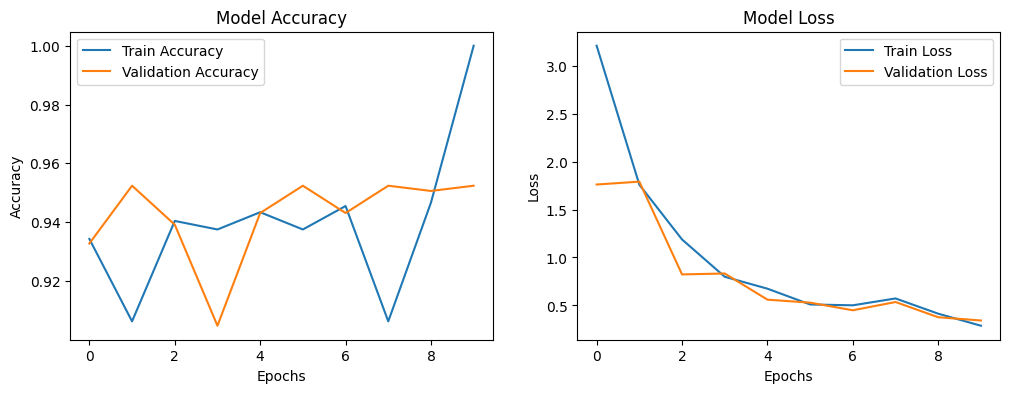

In [32]:
# Visualize accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()






In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = network.predict(val_generator, steps=val_generator.samples // val_generator.batch_size, verbose=1)

y_pred_classes = np.argmax(y_pred, axis=1)

y_true = val_generator.classes

cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2'], yticklabels=['Class 0', 'Class 1', 'Class 2'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


229/229 ━━━━━━━━━━━━━━━━━━━━ 523s 2s/step


ValueError: Found input variables with inconsistent numbers of samples: [7349, 7328]

In [4]:
print(f"Number of validation samples: {val_generator.samples}")
print(f"Number of true labels: {len(y_true)}")

Number of validation samples: 7349
Number of true labels: 7349


In [6]:
network.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 4, 4, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       2,097,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,812,867 (64.14 MB)

 Trainable params: 2,098,179 (8.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)